In [83]:
# Import the necessary libraries that will be used in this code - pandas for data manipulation, numpy for numerical calculations, and seaborn for data visualization. The collections library is also imported to use the Counter function.
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt


In [80]:
df = pd.read_csv("Resources/online_shoppers_intention.csv")
df.head()
print(df.dtypes)


Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object


In [91]:
non_numeric_columns = 'Month', 'VisitorType', 'Weekend', 'Revenue'

# Create an instance of the OrdinalEncoder
encoder = OrdinalEncoder()

for col in non_numeric_columns:
    encoder.fit(df[[col]])
    df[col] = encoder.transform(df[[col]])


In [92]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


In [94]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=150)

Text(0.5, 0, 'Feature Importance')

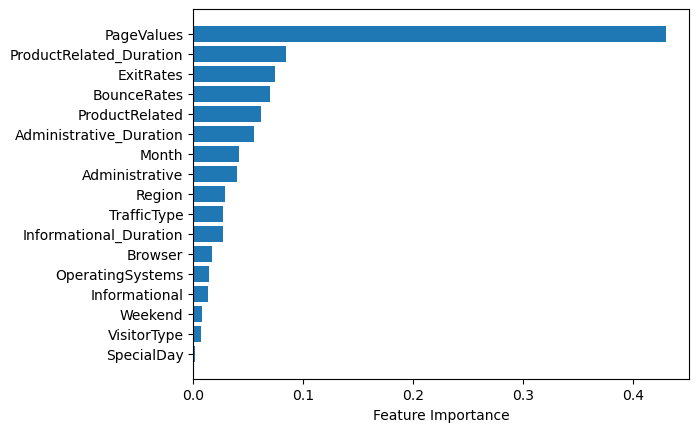

In [98]:
# create a list of column labels from the integer indices
labels = X.columns[sort]

# plot the feature importances with the column labels
plt.barh(labels, rf.feature_importances_[sort])
plt.xlabel("Feature Importance")


In [48]:
# load dataset
df = pd.read_csv("Resources/online_shoppers_intention.csv")
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

ValueError: zero-size array to reduction operation fmin which has no identity

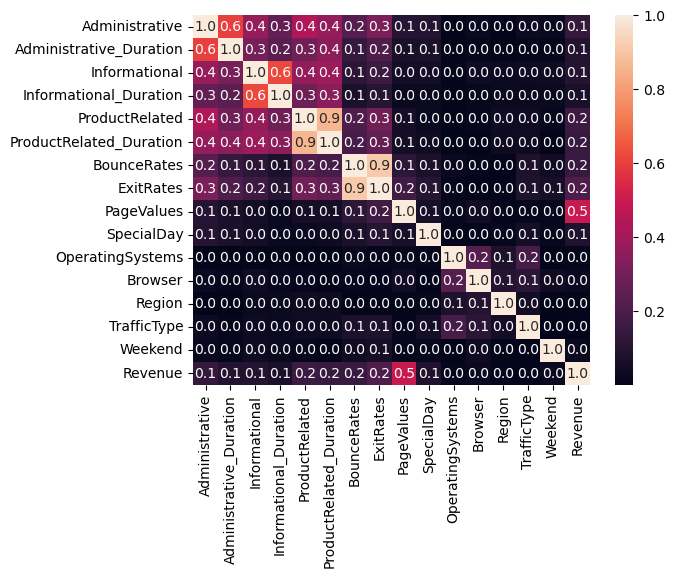

In [64]:

corr_matrix = df.corr().abs()

sns.heatmap(corr_matrix, annot=True, fmt='.1f')

# Replace diagonal values with 0
np.fill_diagonal(corr_matrix.values, 0)

# Unstack the correlation matrix into a Series
corr_unstacked = corr_matrix.unstack()

# Remove duplicate correlations by filtering out those with indices in alphabetical order
unique_corr = corr_unstacked[corr_unstacked.index.get_level_values(
    0) < corr_unstacked.index.get_level_values(1)]

# Sort correlations in descending order
sorted_corr = unique_corr.sort_values(ascending=False)

# Set a correlation threshold
corr_threshold = 0.7

# Identify variables with low correlation
low_corr_vars = set()
for idx, value in sorted_corr.items():
    if value < corr_threshold:
        low_corr_vars.add(idx[0])
        low_corr_vars.add(idx[1])

# Drop variables with low correlation
df_filtered = df.drop(columns=low_corr_vars)

# Compute the new correlation matrix
corr_matrix_filtered = df_filtered.corr().abs()

# Plot the heatmap of the filtered correlation matrix
sns.heatmap(corr_matrix_filtered, annot=True, fmt='.1f')

In [ ]:
# display the count of unique values of 'Revenue' column and visualize it using a countplot
print(Counter(X['Revenue']))
sns.countplot(X['Revenue'])

### The get_dummies method from pandas is used to one-hot encode categorical variables in the dataset (VisitorType and Month). The astype method is used to convert the Weekend and Revenue columns to integer data types.

In [ ]:
# create dummy variables for 'VisitorType' and 'Month' columns and convert 'Weekend' and 'Revenue' columns to int data type
df = pd.get_dummies(X, columns=['VisitorType', 'Month'])
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)

In [ ]:
# define a function to calculate the average time spent by a user on each category (administrative, informational, and product related)
def AvgMinutes(Count, Duration):
    if Duration == 0:
        output = 0
    elif Duration != 0:
        output = float(Duration)/float(Count)
    return output

In [ ]:
# apply the 'AvgMinutes' function to calculate the average time spent by a user on each category and create new features
Columns = [['Administrative', 'Administrative_Duration'], 
           ['Informational', 'Informational_Duration'], 
           ['ProductRelated', 'ProductRelated_Duration']]

In [ ]:
for col in Columns:
    X['Avg'+col[0]] = X.apply(lambda x: AvgMinutes(Count=x[col[0]], Duration=x[col[1]]), axis=1)


In [ ]:
# drop the original columns used to calculate average time spent
X.drop(['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration'], axis=1, inplace=True)


In [ ]:
from sklearn.model_selection import train_test_split
# split data into train and test sets
X = df.drop('Revenue', axis=1)
y = df['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
# scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from keras.models import Sequential,Model
from keras.layers import Dense, Activation, Dropout

#Build a neural network model using Keras
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the model and fit it to the training data
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

In [ ]:
# make predictions on the test data and evaluate the model's performance
y_pred = model.predict_classes(X_test_scaled)
result_dict = summarize_classification(y_test, y_pred)
print(result_dict)